In [8]:
import sys, os
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from pathlib import Path

from allen_v1dd.client import OPhysClient

sys.path.insert(0, '/home/naomi/Desktop/code/v1dd-public/analysis-runner')
import decoding

In [9]:
mouse_id = 'M427836'
col_vol_str = '22'
plane = 3
plane_name = f"Plane_{plane}"

# DATA_DIR = Path("/home/roozbehf/Documents/v1dd_arefeh/V1_DD_NWBs/")
DATA_DIR = Path("/home/naomi/Desktop/data/V1dd_nwbs/")
assert DATA_DIR.exists()
DATA_DIR.resolve()
client =  OPhysClient(DATA_DIR)
session = client.load_ophys_session(f"{mouse_id}_{col_vol_str}")

dff_traces = session.get_traces(trace_type='dff', plane=plane)

In [10]:
# stim = "natural_images_12"
# decode_dim = "image_index"
stim = "drifting_gratings_full"
decode_dim = "direction"

x_data = decoding.get_X_data(session, plane, stim)  # T x N
y_data = decoding.get_Y_data(session, plane, stim, decode_dim=decode_dim)

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

param_grid = {'n_neighbors': list(range(1, len(y_train) // 5 + 1))}  # 5-fold cross-validation

knn = KNeighborsClassifier(metric='correlation')
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid_search.fit(x_train, y_train)
best_k = grid_search.best_params_['n_neighbors']
print(f"Optimal k: {best_k}")

knn = KNeighborsClassifier(n_neighbors=best_k, metric='correlation')
knn.fit(x_train, y_train)
metrics.accuracy_score(y_val, knn.predict(x_val))

Optimal k: 15


0.28205128205128205

In [11]:
other_stim = "drifting_gratings_windowed"
decode_dim = "direction"

x_data_other = decoding.get_X_data(session, plane, other_stim)  # T x N
y_data_other = decoding.get_Y_data(session, plane, other_stim, decode_dim=decode_dim)

metrics.accuracy_score(y_data_other, knn.predict(x_data_other))

0.3385416666666667

### Plotting some results

In [23]:
from v1dd_public import ARTIFACT_DIR
import pandas as pd
import numpy as np

In [27]:
mouse_colors = {'slc2': "#66CCEE", 'slc4': "#228833", 'slc5': '#CCBB44', 'teto1': '#EE6677'}
mice = ['slc2', 'slc4', 'slc5', 'teto1']
mouse_ids = ["M409828", "M416296", "M427836", "M438833"]
z_groups_high_to_low = [[575, 600, 625], [650, 675, 700, 725], [500, 525, 550], [482, 498, 514], [434, 450, 466], \
    [386, 402, 418], [338, 354, 370], [290, 306, 322], [242, 258, 274], [194, 210, 226], [146, 162, 178], [98, 114, 130], [50, 66, 82]]
z_groups_low_to_high = [[50, 66, 82], [98, 114, 130], [146, 162, 178], [194, 210, 226], [242, 258, 274], [290, 306, 322], [338, 354, 370], \
    [386, 402, 418], [434, 450, 466], [482, 498, 514], [500, 525, 550], [575, 600, 625], [650, 675, 700, 725]]

z_groups_high_to_low = [[50], [66], [82], [98], [114], [130], [146], [162], [178], [194], [210], [226], \
    [242], [258], [274], [290], [306], [322], [338], [354], [370], [386], [402], [418], \
    [434], [450], [466], [482], [498], [514], [500], [525], [550], [575], [600], [625], \
    [650], [675], [700], [725]]
z_groups_low_to_high = [[50], [66], [82], [98], [114], [130], [146], [162], [178], [194], [210], [226], \
    [242], [258], [274], [290], [306], [322], [338], [354], [370], [386], [402], [418], \
    [434], [450], [466], [482], [498], [514], [500], [525], [550], [575], [600], [625], \
    [650, 675, 700, 725]]

stim_types = [
    "drifting_gratings_full", 
    "drifting_gratings_windowed", 
    "natural_images_12", 
    "natural_images"
    ]
decode_dims = {
    "drifting_gratings_full": "direction",
    "drifting_gratings_windowed": "direction",
    "natural_images_12": "image_index",
    "natural_images": "image_index"
               }

multi_stim_pairs = {
        "drifting_gratings_full": "drifting_gratings_windowed",
        "drifting_gratings_windowed": "drifting_gratings_full",
        "natural_images_12": "natural_images",
        "natural_images": "natural_images_12",
    }

repetitions = 1000

chance = {
    "drifting_gratings_full_direction": 1/12, 
    "drifting_gratings_full_spatial": 1/2, 
    "drifting_gratings_full_direction_spatial": 1/24, 
    "drifting_gratings_windowed_direction": 1/12, 
    "drifting_gratings_windowed_spatial": 1/2, 
    "drifting_gratings_windowed_direction_spatial": 1/24, 
    "natural_images_12_image_index": 1/12,
    "natural_images_image_index": 1/118}

depth_mapping = {
    66: [50, 66, 82],
    114: [98, 114, 130], 
    162: [146, 162, 178],
    210: [194, 210, 226],
    258: [242, 258, 274],
    306: [290, 306, 322],
    354: [338, 354, 370],
    402: [386, 402, 418],
    450: [434, 450, 466],
    498: [482, 498, 514]
}

depths = [66,
    114, 
    162,
    210,
    258,
    306,
    354,
    402,
    450,
    498]

all_depths = [
    50, 66, 82,
    98, 114, 130,
    146, 162, 178,
    194, 210, 226,
    242, 258, 274,
    290, 306, 322,
    338, 354, 370,
    386, 402, 418,
    434, 450, 466,
    482, 498, 514,
    500, 525, 550, 575, 600, 625, 650, 675, 700, 725
]
all_depths.sort()

In [29]:
all_results_df = pd.read_pickle(os.path.join(ARTIFACT_DIR, "decoding_analyses/2025_0728_5_Boot1_Reps1.pkl"))
all_results_df

,mouse_id,column_id,volume_id,plane,repetition_num,val_accuracies,val_accuracies_mean,val_accuracies_std,test_accuracies,test_accuracies_mean,...,shuf_val_accuracies_std,shuf_test_accuracies,shuf_test_accuracies_mean,shuf_test_accuracies_std,num_k_neighbors,shuf_num_k_neighbors,train_stim_type,test_stim_type,decode_dim,depth
0,427836,3,2,5,0,"[0.41025641025641024, 0.38461538461538464, 0.4...",0.400000,0.026149,"[0.203125, 0.16145833333333334, 0.166666666666...",0.169792,...,0.037684,"[0.11979166666666667, 0.09375, 0.0572916666666...",0.086458,0.020466,"[7, 11, 6, 11, 13]","[7, 7, 10, 1, 13]",drifting_gratings_full,drifting_gratings_windowed,direction,210
0,438833,4,2,1,0,"[0.5641025641025641, 0.5128205128205128, 0.384...",0.471795,0.066072,"[0.21875, 0.20833333333333334, 0.203125, 0.197...",0.213542,...,0.026149,"[0.11979166666666667, 0.11458333333333333, 0.0...",0.105208,0.016601,"[1, 1, 4, 2, 4]","[16, 7, 18, 12, 3]",drifting_gratings_full,drifting_gratings_windowed,direction,146
0,438833,5,2,3,0,"[0.2564102564102564, 0.38461538461538464, 0.30...",0.302564,0.044114,"[0.2864583333333333, 0.234375, 0.234375, 0.260...",0.262500,...,0.045868,"[0.046875, 0.078125, 0.07291666666666667, 0.11...",0.084375,0.025388,"[4, 3, 2, 1, 5]","[15, 7, 30, 1, 2]",drifting_gratings_full,drifting_gratings_windowed,direction,178
0,438833,4,2,2,0,"[0.5641025641025641, 0.28205128205128205, 0.41...",0.394872,0.099440,"[0.2760416666666667, 0.28125, 0.3125, 0.25, 0....",0.282292,...,0.038376,"[0.11979166666666667, 0.0625, 0.08333333333333...",0.078125,0.027756,"[1, 1, 1, 1, 1]","[30, 3, 27, 12, 5]",drifting_gratings_full,drifting_gratings_windowed,direction,162
0,416296,2,4,3,0,"[0.2702702702702703, 0.08108108108108109, 0.29...",0.254054,0.091414,"[0.15217391304347827, 0.22826086956521738, 0.1...",0.190217,...,0.027562,"[0.059782608695652176, 0.08695652173913043, 0....",0.086957,0.025024,"[3, 7, 5, 23, 4]","[1, 21, 13, 9, 24]",drifting_gratings_full,drifting_gratings_windowed,direction,370
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,409828,2,3,6,0,"[0.021164021164021163, 0.005291005291005291, 0...",0.016931,0.009103,"[0.016666666666666666, 0.0, 0.0104166666666666...",0.010417,...,0.006170,"[0.03333333333333333, 0.022916666666666665, 0....",0.017917,0.010425,"[139, 142, 90, 73, 136]","[3, 4, 27, 149, 136]",natural_images,natural_images_12,image_index,322
0,409828,3,3,1,0,"[0.010582010582010581, 0.005291005291005291, 0...",0.010582,0.003346,"[0.016666666666666666, 0.022916666666666665, 0...",0.011667,...,0.008466,"[0.0, 0.022916666666666665, 0.0229166666666666...",0.022500,0.012247,"[58, 23, 117, 84, 151]","[1, 131, 4, 46, 7]",natural_images,natural_images_12,image_index,242
0,416296,5,3,1,0,"[0.1111111111111111, 0.10052910052910052, 0.06...",0.089947,0.019797,"[0.0125, 0.020833333333333332, 0.0208333333333...",0.017500,...,0.002116,"[0.0375, 0.00625, 0.03333333333333333, 0.00833...",0.020417,0.012802,"[12, 12, 8, 8, 5]","[4, 101, 107, 1, 103]",natural_images,natural_images_12,image_index,242
0,409828,4,2,6,0,"[0.005291005291005291, 0.021164021164021163, 0...",0.016931,0.007019,"[0.058333333333333334, 0.05, 0.047916666666666...",0.044167,...,0.005396,"[0.014583333333333334, 0.01875, 0.008333333333...",0.015000,0.004449,"[2, 27, 13, 52, 23]","[104, 28, 74, 18, 4]",natural_images,natural_images_12,image_index,226


In [30]:
# Organize data into a 5D array
# Dimensions: (stim_type (i.e. train_stim_type), mouse_id, column_id, depth, 5 folds)

mouse_ids_mod = [409828, 416296, 427836, 438833]
column_ids = [1, 2, 3, 4, 5]

n_depths = len(all_depths)
n_mice = len(mouse_ids_mod)
n_columns = len(column_ids)
n_stims = len(stim_types)
data = np.zeros((n_stims, n_mice, n_columns, n_depths, 5))
shuf_data = np.zeros((n_stims, n_mice, n_columns, n_depths, 5))

for stim_idx, train_stim_type in enumerate(stim_types):
    decode_dim = decode_dims[train_stim_type]
    test_stim_type = multi_stim_pairs[train_stim_type]
    print(f"Processing {train_stim_type} (TRAINING) and {test_stim_type} (TESTING) with decode_dim {decode_dim}")
    for mouse_idx, mouse_id in enumerate(mouse_ids_mod):
        for column_idx, column_id in enumerate(column_ids):
            for depth_idx, depth in enumerate(all_depths):
                    test_accuracies = all_results_df[
                        (all_results_df['mouse_id'] == mouse_id) & 
                        (all_results_df['depth'] == depth) &
                        (all_results_df['train_stim_type'] == train_stim_type) &
                        # (all_results_df['decode_dim'] == decode_dim) & 
                        (all_results_df['column_id'] == column_id)
                        ].test_accuracies       # Note, this includes 5 folds
                        
                    if len(test_accuracies) > 0:
                        data[stim_idx, mouse_idx, column_idx, depth_idx, :] = test_accuracies.values[0]
                    else:
                        # print(f"Missing data for {stim_type}, {decode_dim}, {mouse_id}, {column_id}, {depth}")
                        data[stim_idx, mouse_idx, column_idx, depth_idx, :] = np.nan
                        continue
                        
                    shuf_test_accuracies = all_results_df[
                        (all_results_df['mouse_id'] == mouse_id) & 
                        (all_results_df['depth'] == depth) &
                        (all_results_df['train_stim_type'] == train_stim_type) &
                        # (all_results_df['decode_dim'] == decode_dim) & 
                        (all_results_df['column_id'] == column_id)
                    ].shuf_test_accuracies

                    if len(shuf_test_accuracies) > 0:
                        shuf_data[stim_idx, mouse_idx, column_idx, depth_idx, :] = shuf_test_accuracies.values[0]
                    else:
                        # print(f"Missing shuffled data for {stim_type}, {decode_dim}, {mouse_id}, {column_id}, {depth}")
                        shuf_data[stim_idx, mouse_idx, column_idx, depth_idx, :] = np.nan
                        continue
                

    data[stim_idx, :, :, :, :] /= chance[f"{train_stim_type}_{decode_dim}"]
    shuf_data[stim_idx, :, :, :, :] /= chance[f"{train_stim_type}_{decode_dim}"]

Processing drifting_gratings_full (TRAINING) and drifting_gratings_windowed (TESTING) with decode_dim direction
Processing drifting_gratings_windowed (TRAINING) and drifting_gratings_full (TESTING) with decode_dim direction
Processing natural_images_12 (TRAINING) and natural_images (TESTING) with decode_dim image_index
Processing natural_images (TRAINING) and natural_images_12 (TESTING) with decode_dim image_index


In [31]:
import matplotlib.pyplot as plt

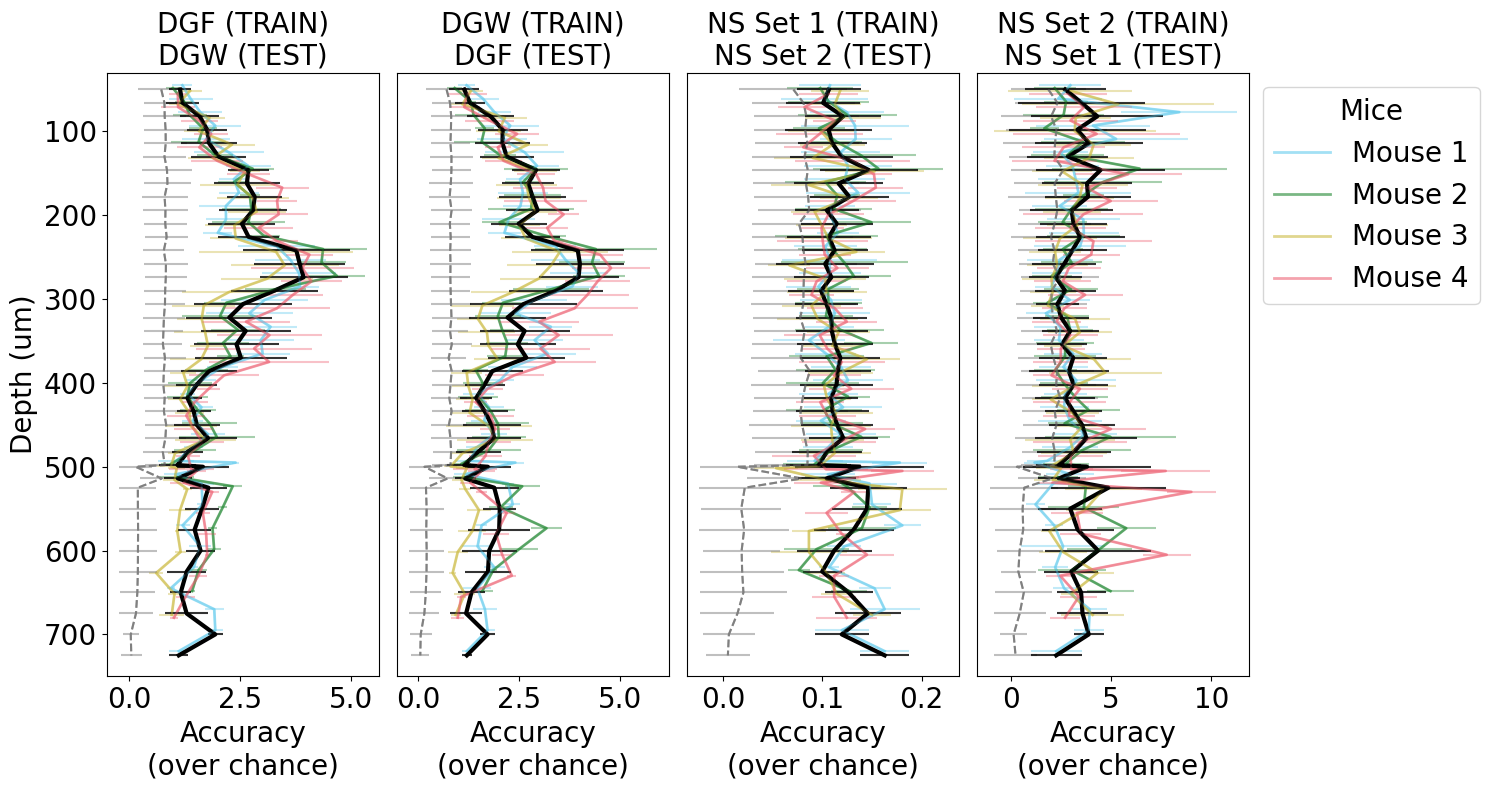

In [37]:
# Plot the results as a lineplot 

# Add some jitter to visualize the individual mice
jitter_amount = 5
jitter_step = jitter_amount * 2 / (n_mice - 1)
jitter_values = np.linspace(-jitter_amount, jitter_amount, n_mice)
fixed_jitters = np.tile(jitter_values, (n_depths, 1))

titles = [
    'DGF (TRAIN)\nDGW (TEST)',
    'DGW (TRAIN)\nDGF (TEST)',
    'NS Set 1 (TRAIN)\nNS Set 2 (TEST)',
    'NS Set 2 (TRAIN)\nNS Set 1 (TEST)',
]

fontsize = 20

fig = plt.figure(figsize=(15, 8))


for stim_idx, stim_type in enumerate(stim_types):
    ax = plt.subplot(1, n_stims, stim_idx + 1)

    # Plot data
    for mouse_idx, mouse_id in enumerate(mice):
        mouse_color = mouse_colors[mouse_id]

        # Plot data
        means, std_errors = [], []
        
        for depth_idx, depth in enumerate(all_depths):
            data_values = data[stim_idx, mouse_idx, :, depth_idx, :]
            if np.all(np.isnan(data_values)):
                means.append(np.nan), std_errors.append(np.nan)
                continue

            mean = np.nanmean(data_values)
            std_error = np.nanstd(data_values)
            means.append(mean), std_errors.append(std_error)
        
        plt.errorbar(means, all_depths + fixed_jitters[:, mouse_idx], xerr=std_errors, fmt='-', color=mouse_color, label=mouse_id, capsize=0, alpha=0.4)
        plt.plot(means, all_depths + fixed_jitters[:, mouse_idx], '-', color=mouse_color, linewidth=2, alpha=0.6)
    

    # Plot shuffled data (average over mice for visualization, so just need to iterate over depths)
    shuf_means, shuf_std_errors = [], []
    for depth_idx, depth in enumerate(all_depths):
        shuf_data_values = shuf_data[stim_idx, :, :, depth_idx, :]
        if np.all(np.isnan(shuf_data_values)):
            shuf_means.append(np.nan), shuf_std_errors.append(np.nan)
            continue
        shuf_mean = np.nanmean(shuf_data_values)
        shuf_std_error = np.nanstd(shuf_data_values)
        shuf_means.append(shuf_mean), shuf_std_errors.append(shuf_std_error)

    plt.errorbar(shuf_means, all_depths, xerr=shuf_std_errors, fmt='--', color='grey', label='Shuffled', capsize=0, alpha=0.5)
    plt.plot(shuf_means, all_depths, '--', color='grey', linewidth=1.5)

    # Plot overall averages 
    overall_means, overall_std_errors = [], []
    for depth_idx, depth in enumerate(all_depths):
        overall_data_values = data[stim_idx, :, :, depth_idx, :]
        if np.all(np.isnan(overall_data_values)):
            overall_means.append(np.nan), overall_std_errors.append(np.nan)
            continue
        overall_mean = np.nanmean(overall_data_values)
        overall_std_error = np.nanstd(overall_data_values)
        overall_means.append(overall_mean), overall_std_errors.append(overall_std_error)
    
    plt.errorbar(overall_means, all_depths, xerr=overall_std_errors, fmt='-', color='black', label='Overall Mean', capsize=0, alpha=0.8)
    plt.plot(overall_means, all_depths, '-', color='black', linewidth=3)

    if stim_idx == 0:
        plt.yticks(fontsize=fontsize)
        plt.ylabel('Depth (um)', fontsize=fontsize)
    elif stim_idx == n_stims - 1:
        plt.legend(['Mouse 1', 'Mouse 2', 'Mouse 3', 'Mouse 4'], loc='upper left', bbox_to_anchor=(1, 1), title='Mice', fontsize=fontsize, title_fontsize=fontsize)
        plt.yticks([])
    else:
        plt.yticks([])

    ax.set_ylim(30, 750)
    ax.set_title(titles[stim_idx], fontsize=fontsize)
    ax.set_xlabel('Accuracy\n(over chance)', fontsize=fontsize)
    ax.locator_params(axis='x', nbins=3)
    plt.xticks(fontsize=fontsize)
    plt.gca().invert_yaxis()

plt.tight_layout()
# plt.savefig(os.path.join(ARTIFACT_DIR, 'decoding_analyses', f'nobootstrapping_decoding_results.svg'), dpi=300)